In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import math
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import spatial
%matplotlib inline

In [2]:
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
# data_path = r'C:\Users\johnny.wong\PycharmProjects\NBA pricing\Personal\Data\nba_odds_raw.csv'
data_path = r'C:\Users\johnn\Desktop\github\nba_stats\Data\nba_odds_raw.csv'
raw_odds = pd.read_csv(data_path)

clean_odds = raw_odds.copy()
clean_odds['date_string'] = clean_odds.apply(lambda row:str(row.DD)+'-'+str(row.MM)+'-'+str(row.YY), axis=1)
clean_odds['Date'] = clean_odds.date_string.apply(lambda date_str: dt.datetime.strptime(date_str, '%d-%b-%Y'))

clean_odds['Avg_A_odds'] = clean_odds.apply(lambda row:np.nanmean([row['Away odds 1'], row['Away odds 2'], 
                                                                   row['Away odds 3']]), axis=1)
clean_odds['Avg_H_odds'] = clean_odds.apply(lambda row:np.nanmean([row['Home odds 1'], row['Home odds 2'], 
                                                                   row['Home odds 3']]), axis=1)

clean_odds['IP'] = 1/clean_odds.Avg_H_odds + 1/clean_odds.Avg_A_odds
clean_odds['Standardised_H_odds'] = clean_odds.Avg_H_odds * clean_odds.IP
clean_odds['Standardised_A_odds'] = clean_odds.Avg_A_odds * clean_odds.IP
clean_odds['Standardised_IP'] = 1/clean_odds['Standardised_H_odds'] + 1/clean_odds['Standardised_A_odds']
clean_odds['favourite_odds'] = clean_odds.apply(lambda row: min(row.Standardised_H_odds, row.Standardised_A_odds), axis=1)

# Remove bad data
clean_odds = clean_odds[raw_odds['Total score'] > 50]
clean_odds = clean_odds[~clean_odds.Avg_A_odds.isnull()]
assert len(clean_odds[(clean_odds.Standardised_IP - 1).abs() > 0.01]) == 0
clean_odds.head()

C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


,YY,DD,MM,Seasons,Home team,Away team,Home ID,Away ID,End of regulation score,Home final score,Away final score,Winning team,Total score,Home odds 1,Away odds 1,Home odds 2,Away odds 2,Home odds 3,Away odds 3,date_string,Date,Avg_A_odds,Avg_H_odds,IP,Standardised_H_odds,Standardised_A_odds,Standardised_IP,favourite_odds
0,2019,11,Feb,2018/2019,Golden State Warriors,Miami Heat,GSW,MIA,NaN,120.0,118.0,H,238.0,1.08,10.40,1.08,10.16,1.07,9.50,11-Feb-2019,2019-02-11,10.020000,1.076667,1.028593,1.107452,10.306502,1.0,1.107452
1,2019,11,Feb,2018/2019,Atlanta Hawks,Orlando Magic,ATL,ORL,NaN,108.0,124.0,A,232.0,2.06,1.62,2.04,1.87,2.20,1.71,11-Feb-2019,2019-02-11,1.733333,2.100000,1.053114,2.211538,1.825397,1.0,1.825397
2,2019,10,Feb,2018/2019,Sacramento Kings,Phoenix Suns,SAC,PHX,NaN,117.0,104.0,H,221.0,1.19,3.90,1.24,4.65,1.26,4.00,10-Feb-2019,2019-02-10,4.183333,1.230000,1.052052,1.294024,4.401084,1.0,1.294024
3,2019,10,Feb,2018/2019,Philadelphia 76ers,Los Angeles Lakers,PHI,LAL,NaN,143.0,120.0,H,263.0,1.33,3.00,1.34,3.56,1.34,3.35,10-Feb-2019,2019-02-10,3.303333,1.336667,1.050854,1.404642,3.471322,1.0,1.404642
4,2019,10,Feb,2018/2019,Dallas Mavericks,Portland Trail Blazers,DAL,POR,NaN,102.0,101.0,H,203.0,2.61,1.57,2.62,1.56,1.74,2.15,10-Feb-2019,2019-02-10,1.760000,2.323333,0.998598,2.320076,1.757532,1.0,1.757532


Plot the home winning margin against the home implied probabilities

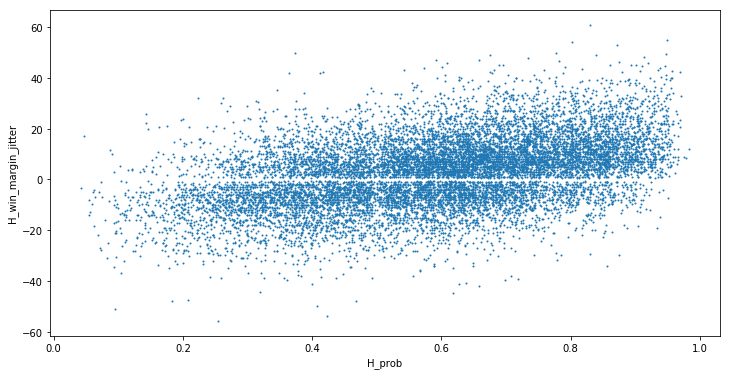

In [4]:
clean_odds['H_prob'] = 1/clean_odds['Standardised_H_odds']
clean_odds['A_prob'] = 1/clean_odds['Standardised_A_odds']
clean_odds['H_win_margin'] = clean_odds['Home final score'] - clean_odds['Away final score']
clean_odds['H_win_margin_jitter'] = clean_odds['H_win_margin'] + np.random.normal(scale=0.2, size=len(clean_odds))
clean_odds.plot(x='H_prob', y='H_win_margin_jitter', kind='scatter', figsize=(12, 6), s=1)

Clear relationship between the probability of a winning, and winning margin. Looks fairly linear, let's run a regression.

In [11]:
margin_prob_regr = LinearRegression()
margin_prob_regr.fit(clean_odds.H_prob.reshape(-1, 1), clean_odds.H_win_margin)
print('Intercept {:.2f}\nGradient {:.2f}'.format(margin_prob_regr.intercept_, margin_prob_regr.coef_[0]))
print('At 50% win, predicts {:.2f}'.format(margin_prob_regr.predict([[0.5]])[0]))

Intercept -15.79
Gradient 31.41
At 50% win, predicts -0.09


C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


Good that at 50%, the model spits out a predicted margin very close to 0. This makes sense. As an aside, it seems like home teams have more 90%+ games than 10%- games. Will be something to look into but makes sense due to home court advantage.

## Plotting regression and analysis of residuals

Text(0,0.5,'Home team winning margin')

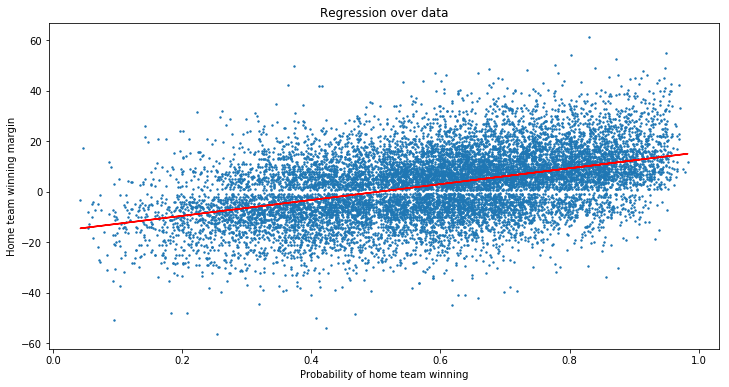

In [37]:
clean_odds['Pred_H_win_margin'] = margin_prob_regr.predict(clean_odds['H_prob'].values.reshape(-1,1))

plt.figure(figsize=(12,6))

plt.scatter(x=clean_odds.H_prob, y=clean_odds.H_win_margin_jitter, s=2)
plt.plot(clean_odds.H_prob,clean_odds.Pred_H_win_margin, 'r-')

plt.title('Regression over data')
plt.xlabel('Probability of home team winning')
plt.ylabel('Home team winning margin')

Text(0,0.5,'Actual home team margin minus expected')

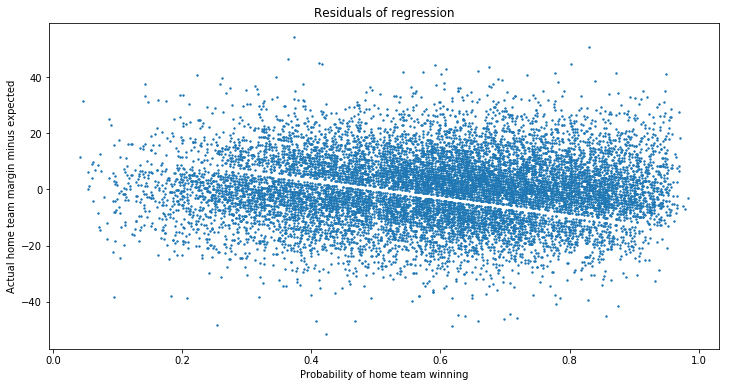

In [40]:
clean_odds['residual'] = clean_odds['H_win_margin'] - clean_odds['Pred_H_win_margin']
plt.figure(figsize=(12,6))

plt.scatter(x=clean_odds.H_prob, y=clean_odds.residual, s=2)

plt.title('Residuals of regression')
plt.xlabel('Probability of home team winning')
plt.ylabel('Actual home team margin minus expected')

After plotting squared residuals, seems a bit heteroskedastic. Looks like there might be more variance around the 40-70% region than the wings.

Text(0.5,1,'Residuals squared')

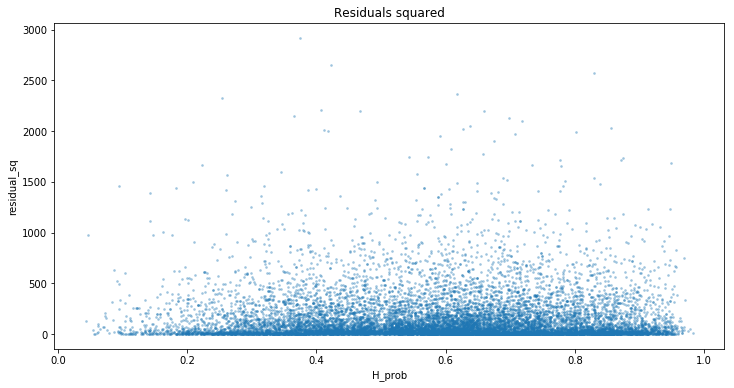

In [82]:
clean_odds['residual_sq'] = clean_odds['residual']  ** 2

clean_odds.plot(x='H_prob', y='residual_sq', kind='scatter', s=3, figsize=(12, 6), alpha=0.3)
plt.title('Residuals squared')

(0, 400)

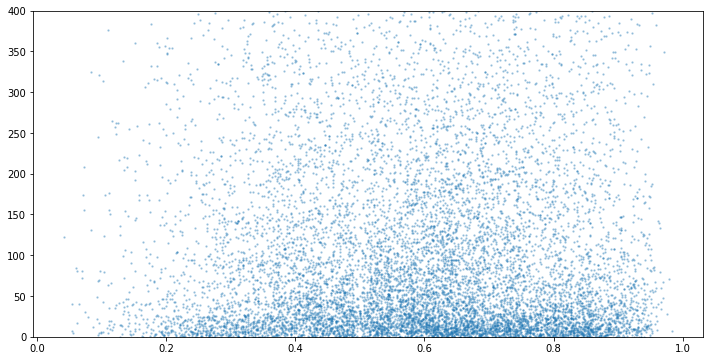

In [80]:
y_upper = 400
plt.figure(figsize=(12,6))
plt.scatter(x=clean_odds['H_prob'], 
            y=clean_odds['residual_sq'] + np.random.normal(scale=10, size=len(clean_odds)),
           s=2, alpha=0.3)
plt.ylim((0, y_upper))

### Testing for heterskedasticity
Hypothesis is that variance decreases at the wings and increases near the 50%, so split the data up and run a regression on the squared residuals to see if there is a significant trend.

In [87]:
h_prob_under_60 = clean_odds[clean_odds.H_prob < 0.6]
h_prob_over_60 = clean_odds[clean_odds.H_prob > 0.6]

under_60_regr = LinearRegression()
under_60_regr.fit(X=h_prob_under_60.H_prob.values.reshape(-1,1), y=h_prob_under_60.residual_sq)

over_60_regr = LinearRegression()
over_60_regr.fit(X=h_prob_over_60.H_prob.values.reshape(-1,1), y=h_prob_over_60.residual_sq)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Text(0.5,0.98,'Residual squared across different subsets')

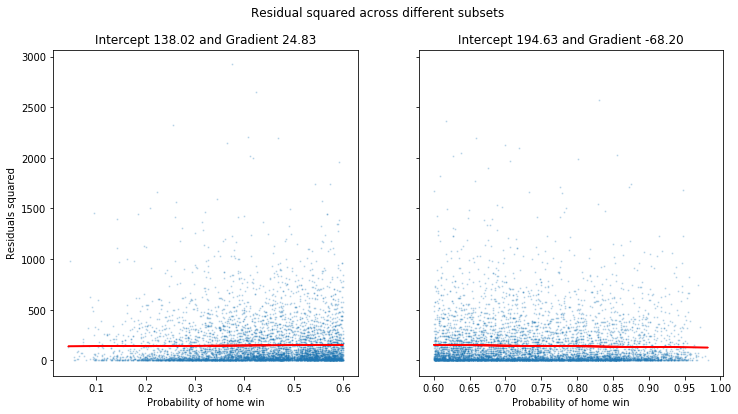

In [104]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,6))

ax[0].scatter(h_prob_under_60.H_prob, h_prob_under_60.residual_sq, s=1, alpha=0.2)
ax[0].plot(h_prob_under_60.H_prob, 
           under_60_regr.predict(h_prob_under_60.H_prob.values.reshape(-1,1)),
          color='r')
ax[0].set_xlabel('Probability of home win')
ax[0].set_ylabel('Residuals squared')
ax[0].set_title('Intercept {:.2f} and Gradient {:.2f}'.format(under_60_regr.intercept_, under_60_regr.coef_[0]))

ax[1].scatter(h_prob_over_60.H_prob, h_prob_over_60.residual_sq, s=1, alpha=0.2)
ax[1].plot(h_prob_over_60.H_prob, 
           over_60_regr.predict(h_prob_over_60.H_prob.values.reshape(-1,1)),
          color='r')
ax[1].set_xlabel('Probability of home win')
ax[1].set_title('Intercept {:.2f} and Gradient {:.2f}'.format(over_60_regr.intercept_, over_60_regr.coef_[0]))

fig.suptitle('Residual squared across different subsets')

For under 60%, a gradient of 24.83 suggests that the difference in variance between a 20% probability and 60% probability is 0.4x24.83 = 9.932, which is significant enough that it shouldn't be ignored.
The regression on the left predicts a variance of 153 for 60% win, while the regression on the right predicts also predicts 153. This is good as it suggests the arbitrarily chosen 60% is probably a good split. Out of curiosity, I wanted to see how a LOESS regression would look on the full dataset before continuing further.

It's hard to see on the left chart the effect of lowess regression, it is clearer to see on the right chart.

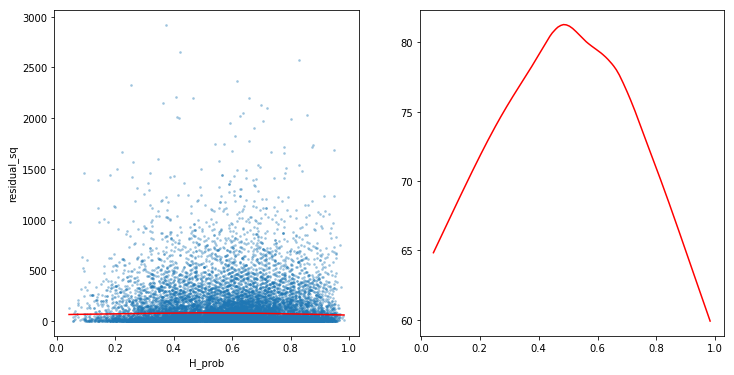

In [144]:
lowess_variance = sm.nonparametric.lowess(clean_odds.residual_sq, clean_odds.H_prob, delta=0.01)

lowess_x = [x[0] for x in lowess_variance]
lowess_y = [y[1] for y in lowess_variance]

fig, ax = plt.subplots(1, 2)
clean_odds.plot(x='H_prob', y='residual_sq', kind='scatter', s=3, figsize=(12, 6), alpha=0.3, ax=ax[0])
ax[0].plot(lowess_x, lowess_y, color='red')
ax[1].plot(lowess_x, lowess_y, color='red')

This turned out to be quite informative! It seems fairly linear from 0 up to around 45% and from about 70% to 100%. I'm going to run the lowess regression over multiple parameters just to see if the shape differs by much.

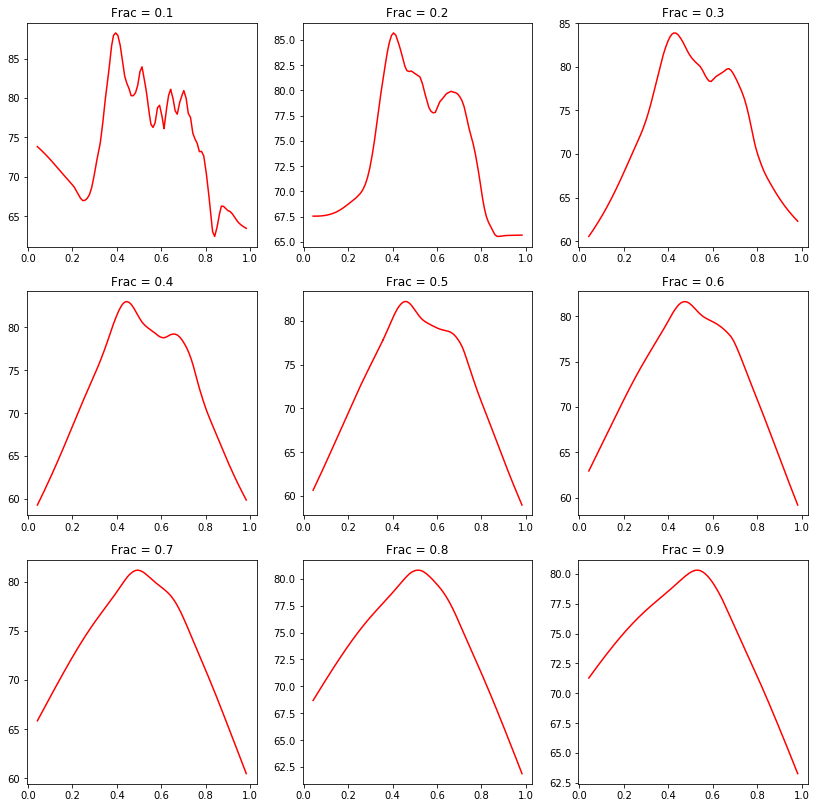

In [141]:
frac_params = np.linspace(0.1, 0.9, 9)

fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(14, 14))

for i, frac in enumerate(frac_params):
    plt.subplot(3, 3, i+1)
    lowess_variance = sm.nonparametric.lowess(clean_odds.residual_sq, clean_odds.H_prob, frac=frac, delta=0.01)
    lowess_x = [x[0] for x in lowess_variance]
    lowess_y = [y[1] for y in lowess_variance]
    plt.plot(lowess_x, lowess_y, color='red')
    plt.title('Frac = {:.1f}'.format(frac))

While there are some weird shapes, frac 0.5 seems smooth enough to make sense whilst capturing important info on the variance, so I will elect to use that as my variance predictor. I tried to split it up until multiple linear regressions below, but it doesn't seem to be very smooth. For now I will give up the parameterisation in favour of smoothness.

In [173]:
h_prob_under_45 = clean_odds[clean_odds.H_prob < 0.45]
h_prob_45_to_70 = clean_odds[(clean_odds.H_prob >= 0.45) & (clean_odds.H_prob <= 0.7)]
h_prob_over_70 = clean_odds[clean_odds.H_prob > 0.7]

under_45_regr = LinearRegression()
under_45_regr.fit(X=h_prob_under_45.H_prob.values.reshape(-1,1), y=h_prob_under_45.residual_sq)

between_45_70_regr = LinearRegression()
between_45_70_regr.fit(X=h_prob_45_to_70.H_prob.values.reshape(-1,1), y=h_prob_45_to_70.residual_sq)

over_70_regr = LinearRegression()
over_70_regr.fit(X=h_prob_over_70.H_prob.values.reshape(-1,1), y=h_prob_over_70.residual_sq)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

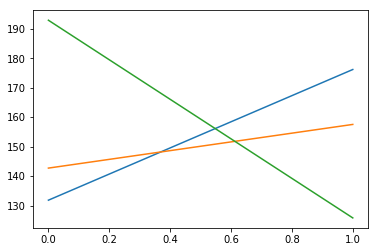

In [174]:
x_0_to_1 = np.linspace(0, 1, 101)
plt.plot(x_0_to_1, under_45_regr.predict(x_0_to_1.reshape(-1,1)))
plt.plot(x_0_to_1, between_45_70_regr.predict(x_0_to_1.reshape(-1,1)))
plt.plot(x_0_to_1, over_70_regr.predict(x_0_to_1.reshape(-1,1)))

In [182]:
def margin_variance(H_prob):
    ''' Returns the variance of the margin based on the probability of the home team winning '''
    if H_prob <=0.45:
        return under_50_regr.predict([[H_prob]])
    elif H_prob <=0.7:
        return between_45_70_regr.predict([[H_prob]])
    else:
        return over_70_regr.predict([[H_prob]])

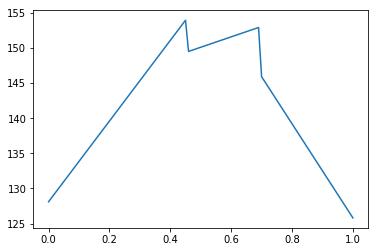

In [181]:
plt.plot(x_0_to_1, [margin_variance(H_prob) for H_prob in x_0_to_1])

In [193]:
lowess_variance = sm.nonparametric.lowess(clean_odds.residual_sq, clean_odds.H_prob, delta=0.01, frac=0.5)
def margin_variance_lowess(H_prob, lowess_model):
    lowess_prob = [[x[0]] for x in lowess_model]
    lowess_var = [y[1] for y in lowess_model]
    
    tree = spatial.KDTree(lowess_prob)
    d, i = tree.query([H_prob])
    
    return lowess_var[i]

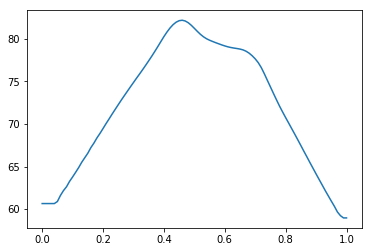

In [195]:
plt.plot(x_0_to_1, [margin_variance_lowess(H_prob, lowess_variance) for H_prob in x_0_to_1])